In [1]:
import os

from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, isnan
from pyspark.ml.regression import LinearRegression

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.pipeline import Pipeline, PipelineModel


spark = SparkSession.builder.getOrCreate()

print(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/21 19:21:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [3]:
data_folder = Path('data/processed')

df = pd.read_csv(data_folder/'time_series.csv')
df

,Country,year,life_exp,hdi_index,co2,gnipc
0,Afghanistan,1990,45.9672,0.273,0.209727,2684.550019
1,Angola,1990,41.8933,NaN,0.429586,4845.706901
2,Albania,1990,73.1439,0.647,1.656902,4742.215529
3,Andorra,1990,78.4063,NaN,7.461153,43773.146500
4,United Arab Emirates,1990,71.9004,0.728,28.277672,102433.136000
...,...,...,...,...,...,...
6235,Samoa,2021,72.7675,0.707,1.238975,5307.953374
6236,Yemen,2021,63.7534,0.455,0.327510,1314.270189
6237,South Africa,2021,62.3410,0.713,7.620420,12948.373250
6238,Zambia,2021,61.2234,0.565,0.357535,3217.767739


<AxesSubplot: >

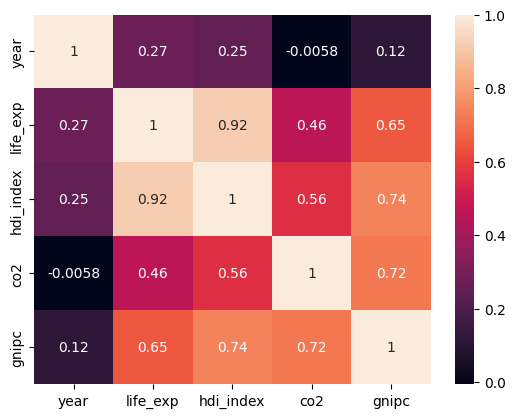

In [4]:
numeric_cols = ['year', 'life_exp', 'hdi_index', 'co2', 'gnipc']
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True)

Bases on this matrix, we can see that the year column doesn't correlate with any other column, so we ignore it
We see that we can use the Human Development Index (`hdi_index`) as a good target for a predictive algorithm.
We can use the variables `life_exp`, `gnipc` and `co2` as predictors

## Modeling

In [5]:
target = 'hdi_index'
features = ['co2', 'life_exp', 'gnipc']

# Remove rows with null values in the feature set
df_clean = df.dropna(axis=0, how='any', subset=features)
df_clean

,Country,year,life_exp,hdi_index,co2,gnipc
0,Afghanistan,1990,45.9672,0.273,0.209727,2684.550019
1,Angola,1990,41.8933,NaN,0.429586,4845.706901
2,Albania,1990,73.1439,0.647,1.656902,4742.215529
3,Andorra,1990,78.4063,NaN,7.461153,43773.146500
4,United Arab Emirates,1990,71.9004,0.728,28.277672,102433.136000
...,...,...,...,...,...,...
6235,Samoa,2021,72.7675,0.707,1.238975,5307.953374
6236,Yemen,2021,63.7534,0.455,0.327510,1314.270189
6237,South Africa,2021,62.3410,0.713,7.620420,12948.373250
6238,Zambia,2021,61.2234,0.565,0.357535,3217.767739


In [6]:
#| output: false
print(f'There are {df_clean.shape[0]} rows in this table')

There are 6053 rows in this table


Let's go with 80/20 split for train/test split

## 80/20 Split

let's shuffle the dataset using pyspark shuffle and then place the rows with the null target values (i.e. null hdi_index values) with the test set.

In [7]:
# Training & Test Split
df_clean
num_records = df_clean.shape[0]
df_spark = spark.createDataFrame(df_clean)

In [8]:
# Random Shuffl
random_shuffle = df_spark.orderBy(rand(42)).select(features+[target])
# Place null values at the last
df_shuffled = random_shuffle.filter(~isnan('hdi_index'))\
    .union(
    random_shuffle.filter(isnan('hdi_index'))
)
split = int(num_records*0.8)

train = df_shuffled.limit(split)
test = df_shuffled.offset(split)

In [9]:
assembler = VectorAssembler(inputCols=features, outputCol='features')
# assembler.transform(train).show()

lr = LinearRegression(labelCol='hdi_index')

pipe = Pipeline(stages=[assembler, lr])
trained_model = pipe.fit(train)

23/10/21 19:21:33 WARN Instrumentation: [64d0cf62] regParam is zero, which might cause numerical instability and overfitting.
23/10/21 19:21:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/10/21 19:21:34 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [10]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = trained_model.transform(test)
evaluator = RegressionEvaluator(labelCol=target)
evaluator.evaluate(predictions.filter(~isnan(target)))

0.056643843399572166

### Save the model

In [11]:
os.makedirs('models', exist_ok=True)
lr_model_path = 'models/lr'
if not os.path.exists(lr_model_path):
    trained_model.save(lr_model_path)

### Load the Model

In [12]:
model = PipelineModel.load('models/lr')
model.transform(test)

DataFrame[co2: double, life_exp: double, gnipc: double, hdi_index: double, features: vector, prediction: double]